<a href="https://colab.research.google.com/github/ProfAI/tf00/blob/master/11%20-%20Serie%20Storiche/weather_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predizione del Meteo

## Importiamo i moduli

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional, GlobalMaxPooling1D

## Scarichiamo i dati

In [20]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2020-07-09 15:40:12--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  49.1MB/s    in 0.3s    

2020-07-09 15:40:12 (49.1 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: jena_climate_2009_2016.csv  


## Definiamo le Costanti

In [21]:
WINDOW_SIZE = 20

## Prepariamo i Dati

In [53]:
df = pd.read_csv("jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [54]:
temp_data = df["T (degC)"].values

In [55]:
def get_xy(data, window_state, target_future=1):

    X = []
    y = []

    for i in range(0, data.shape[0]-window_state*target_future):
      X.append(np.reshape(data[i:i+window_state], (window_state, 1)))
      y.append(data[i+window_state*target_future])

    return np.array(X), np.array(y)


X, y = get_xy(temp_data, WINDOW_SIZE)
print(X.shape)
print(y.shape)

(420531, 20, 1)
(420531,)


In [56]:
def train_test_split_series(X, y, test_size=0.25):

  samples_count = X.shape[0]
  sets_delimiter = samples_count-int((1-test_size)*samples_count)

  X_train = X[:sets_delimiter,:,:]
  X_test = X[sets_delimiter:,:,:]

  y_train = y[:sets_delimiter]
  y_test = y[sets_delimiter:]

  return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split_series(X, y)
print(X_train.shape)
print(X_test.shape)

(105133, 20, 1)
(315398, 20, 1)


In [57]:
mean_value = X_train.mean()
std_value = X_train.std()

X_train = (X_train-mean_value)/std_value
X_test = (X_test-mean_value)/std_value

## Predirre il Meteo 10 minuti nel futuro

In [58]:
model = Sequential()
model.add(LSTM(8, input_shape=[WINDOW_SIZE,1]))
model.add(Dense(1))

In [59]:
model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
3286/3286 [==============================] - 19s 6ms/step - loss: 2.5587
Epoch 2/5
3286/3286 [==============================] - 18s 6ms/step - loss: 0.3043
Epoch 3/5
3286/3286 [==============================] - 18s 6ms/step - loss: 0.1760
Epoch 4/5
3286/3286 [==============================] - 18s 6ms/step - loss: 0.1523
Epoch 5/5
3286/3286 [==============================] - 18s 6ms/step - loss: 0.1442


In [60]:
model.evaluate(X_test, y_test)

9857/9857 [==============================] - 32s 3ms/step - loss: 0.1417


0.14172647893428802

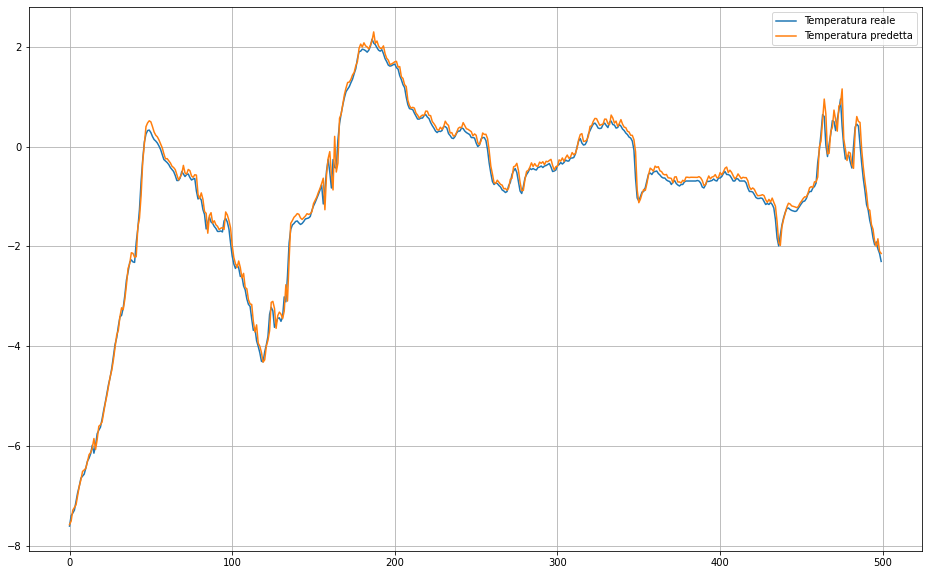

In [61]:
def plot_series_prediction(y_true, y_pred, figsize=(16,10)):
  plt.figure(figsize=figsize)
  plt.grid()
  plt.plot(y_true, label="Temperatura reale")
  plt.plot(y_pred, label="Temperatura predetta")
  plt.legend()

y_pred = model.predict(X_test)
plot_series_prediction(y_test[:500], y_pred[:500])

## Predirre il Meteo 1 Ora nel Futuro

In [32]:
X, y = get_xy(temp_data, 20, target_future=6)

In [34]:
model = Sequential()

model.add(Bidirectional(LSTM(32, return_sequences=True, input_shape=[history_size,1], )))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
#model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

NameError: ignored

In [35]:
model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
3286/3286 [==============================] - 6s 2ms/step - loss: 9.5433
Epoch 2/20
3286/3286 [==============================] - 6s 2ms/step - loss: 9.5433
Epoch 3/20
 415/3286 [==>...........................] - ETA: 5s - loss: 9.5741

KeyboardInterrupt: ignored

In [33]:
model.evaluate(X_test, y_test)

9857/9857 [==============================] - 33s 3ms/step - loss: 0.1416


0.14161550998687744

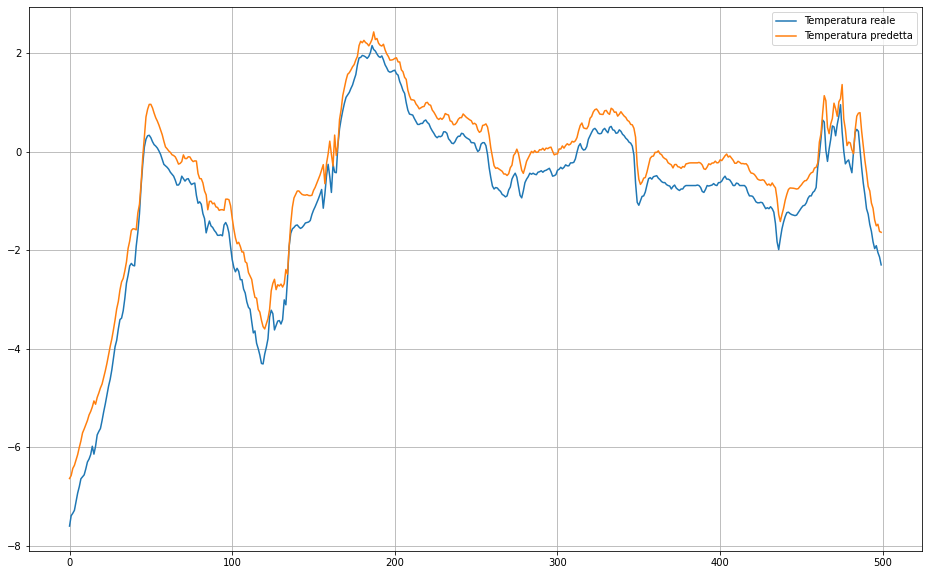

In [ ]:
y_pred = model.predict(X_test)
plot_series_prediction(y_test[:500], y_pred[:500])

## Forecasting

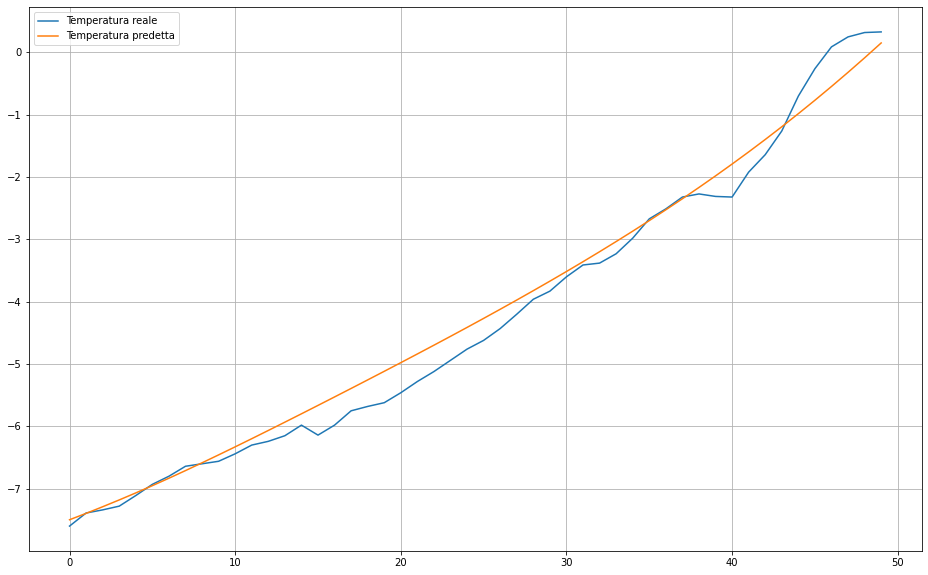

In [91]:
def forecasting(model, x_start, times):

  forecast = []

  for _ in range(times):

    pred = model.predict(x_start.reshape(1, WINDOW_SIZE, 1))[0]
    forecast.append(pred)

    pred_std = (pred-mean_value)/std_value
    x_start = np.append(x_start[1:], pred_std)

  return np.array(forecast)


forecast = forecasting(model, X_test[1,:,:], 50)
plot_series_prediction(y_test[:50], forecast)